## Shannon Moran <br>
Phys 514 <br>
HW 6<br>
Due: Oct 26

Outstanding to-dos:
    - Binder cumulant is exploding beyond critical temperature-- do I need to thermalize for longer?
    - Heat capacity seems wrong

## Import required packages

In [1]:
%matplotlib inline
import numpy as np
from math import *
import matplotlib.pyplot as plt
import time
import random

## Initialize Ising lattice

Set the initial configuration to a random lattice.

In [2]:
def init_lattice(L,p=0.5):
    random_lattice = np.random.random((L,L))
    lattice = (random_lattice<=p)*1
    np.place(lattice,lattice==0,-1)
    return lattice

## Simulate the Ising model using Monte Carlo

Simulate the Ising model,

$$ H = -J\sum_{\langle i,j \rangle}S_iS_j$$

on a square lattice in two dimensions using Metropolis Monte Carlo with single spin flip updates.

### Monte Carlo helper calculations

In [14]:
# Calculate nn spin interactions, taking PBC into account
def nn_spin(spins):
    # Divide by two to avoid double-counting spins
    neighbors = np.copy(spins*(np.roll(spins,+1,axis=1)+np.roll(spins,+1,axis=0)
                               +np.roll(spins,-1,axis=1)+np.roll(spins,-1,axis=0))/2)
    return neighbors


def expectation(A,E,beta):
    return np.sum(A*np.exp(-beta*np.asarray(E)))/np.sum(np.exp(-beta*np.asarray(E)))


# Calculate binder cumulant
def binder_cumulant(M,E,beta):
    M4 = expectation(np.power(M,4),E,beta)
    M2 = expectation(np.power(M,2),E,beta)**2
#     M4 = np.average(np.power(M,4))
#     M2 = np.average(np.power(M,2))**2
#     print(M4,M2)
    return 1-M4/(3*M2)

### Monte Carlo method execution

In [78]:
# Execute single spin flip
def spin_flip(configuration):
    positions = np.arange(configuration.shape[0])
    flip_i = random.choice(positions)
    flip_j = random.choice(positions)
    flipped = np.copy(configuration)
    flipped[flip_i][flip_j] *= -1
    return flipped


# Execute single MC step
def MC_step(config_old,J,beta,status='run'):
    global moves
    config_new = np.copy(spin_flip(config_old))
    E_old = -J*np.sum(nn_spin(config_old))
    E_new = -J*np.sum(nn_spin(config_new))
    E_del = E_new - E_old
    if E_del<0: config = np.copy(config_new); E=E_new
    else:
        p = np.exp(-beta*E_del)
        r = random.random()
        if r<p: config = np.copy(config_new); E=E_new; moves+=1
        else: config = np.copy(config_old); E=E_old
    M = (np.sum(config)/config.shape[0]**2)**2
    if status=="init": return config
    else: return config,E,M 
    

# Execute MC_simulation for specified number of steps
def MC_simulate(lattice,N_run,J,beta,show=False):
    global moves
    E = []
    M = []
    L = lattice.shape[0]
    step = 0
    moves = 0
    while step<N_run:
        step+=1
        lattice,Ei,Mi = np.copy(MC_step(lattice,J,beta))
        E.append(Ei)
        M.append(Mi)
    # Calculate properties
    T = 1/beta
    properties = {
        'E': E,
        'M': M,
        'S': (np.mean(np.power(M,2)/L**2)-(np.average(np.abs(M))**2/(L**2)))/T,
#         'C': (np.mean(np.power(E,2))-np.mean(E)**2)/T**2,
        'C': expectation(np.power(E,2)-expectation(E,E,beta)**2,E,beta)/T**2,
        'U': binder_cumulant(M,E,beta),
    }
    if show==True:
        plt.title("Temperature: %s"%T)
        plt.imshow(lattice,cmap='nipy_spectral',interpolation="none")
        plt.colorbar()
        plt.show()
    else:pass
    return lattice,properties

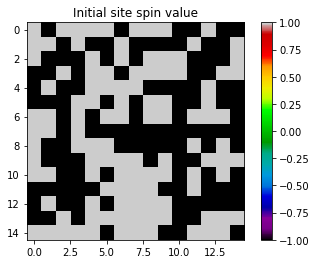

In [73]:
# Validate spin initialization
L = int(15)
lattice0 = np.copy(init_lattice(L))
plt.imshow(lattice0,cmap='nipy_spectral',interpolation="none")
plt.title('Initial site spin value')
plt.colorbar()
plt.show()

In [6]:
# Add a quick demonstration that this works

Move acceptance @ T=0.5: 0.00896
Move acceptance @ T=2.27: 0.13024
Move acceptance @ T=5.0: 0.50136


/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in exp
/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in multiply
/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in double_scalars


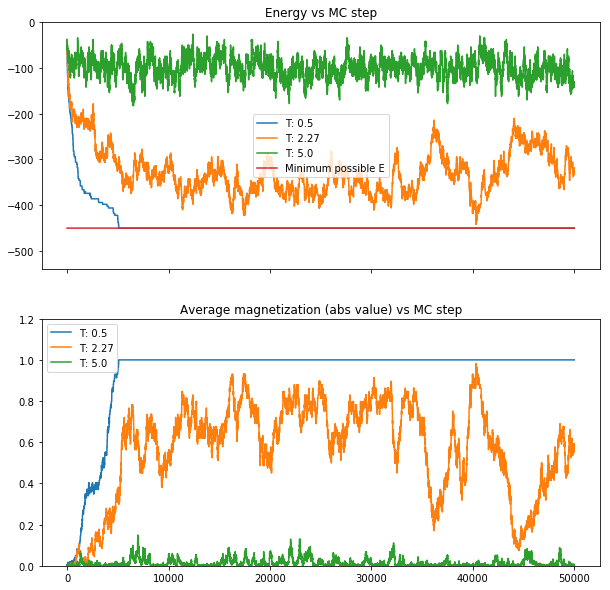

In [80]:
# Set simulation parameters
moves = 0
N_init = 0
N_run = int(5e4)
MC_steps = np.arange(N_run)

# T is in units J/kB
J = 1
T_range = np.asarray([0.5, 2.27, 5.0])

# Run MC simulations over range of temperatures
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(10,10))
for T in T_range:
    _,props = np.copy(MC_simulate(lattice0,N_run,J,1/T,show=False))
    ax1.plot(MC_steps,props['E'],label='T: %s' %T)
    ax2.plot(MC_steps,props['M'],label='T: %s' %T)
    print('Move acceptance @ T=%s: %s'%(T,moves/N_run))
    
# Consolidate plots of results.
E_min = int(-lattice.shape[0]**2*2*J)
ax1.plot(MC_steps,E_min*np.ones(N_run),label='Minimum possible E')
ax1.set_title('Energy vs MC step')
ax1.set_ylim([E_min*1.2, 0])
ax1.legend(loc=0)
ax2.set_title('Average magnetization (abs value) vs MC step')
ax2.set_ylim([0, 1.2])
ax2.legend(loc=0)
plt.show()

## Compute system properties versus T

Compute the expectation values of the absolute value of the magnetization, magnetic susceptibility, the energy, and the specific heat as a function of temperature.

The expectation value of a quantity $A$ at a finite temperature $T$ is given by a sum over all states in the simulation:
$$ \langle A \rangle = \frac{1}{Z}\sum_i A_i exp(\beta E_i) $$

where $\beta=1/kT$, $A_i$ is the value of the quantity $A$ in the configuration $i$ with energy $E_i$.

The partition function is given by:
$$ Z = \sum_i exp(-\beta E_i) $$

This normalizes the probabilities $p_i=exp(\beta E_i)/Z$.

Something is not working-- can use this site for reference to troubleshoot:
https://github.com/prtkm/ising-monte-carlo/blob/master/ising-monte-carlo.org

Good site for checking the physics: http://quantumtheory.physik.unibas.ch/people/bruder/Semesterprojekte2007/p1/

In [64]:
'''
Replace mean and average with expectation in the Monte Carlo simulation function
'''

N_therm = int(3e4)
N_run = int(5e3)

# We keep this lattice size fairly small so that we thermalize more quickly.
L = int(15)
lattice0 = np.copy(init_lattice(L))
T_range = np.linspace(1.0,4.0,10)

reps = 1
U_reps = np.copy(np.zeros((reps,len(T_range))))
M_reps = np.copy(np.zeros((reps,len(T_range))))
S_reps = np.copy(np.zeros((reps,len(T_range))))
C_reps = np.copy(np.zeros((reps,len(T_range))))

for rep in range(reps):
    U = []
    M = []
    S = []
    C = []
    for T in T_range:
        properties = {}    
        lattice,_ = np.copy(MC_simulate(lattice0,N_therm,J,1/T))
        _,properties = np.copy(MC_simulate(lattice,N_run,J,1/T))
        U.append(properties['U'])
    #     M.append(expectation(properties['M'],properties['E'],1/T))
        M.append(np.average(np.asarray(properties['M'])))
        S.append(properties['S'])
        C.append(properties['C'])
    U_reps[rep][:] = U
    M_reps[rep][:] = M
    S_reps[rep][:] = S
    C_reps[rep][:] = C

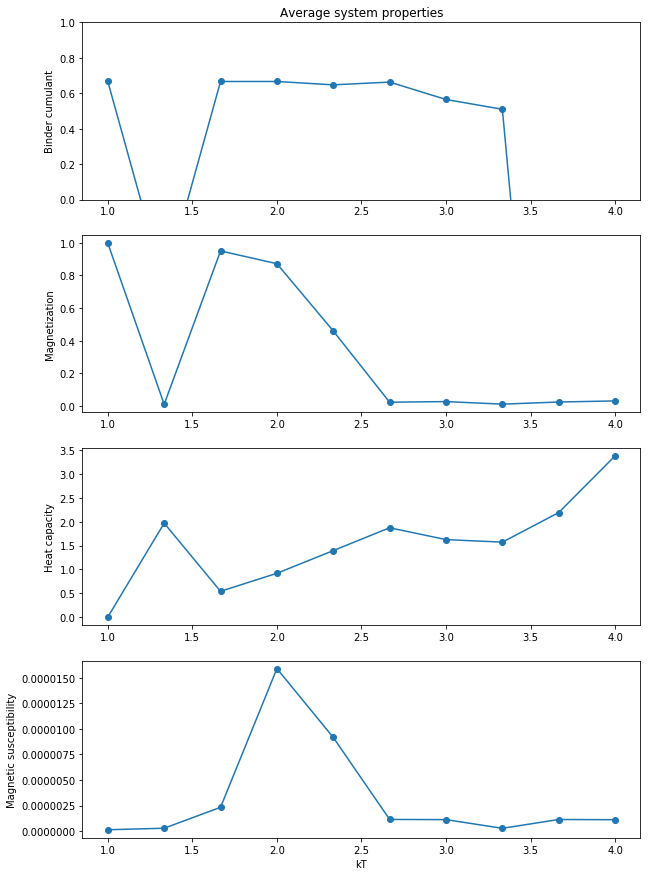

In [65]:
# Plot results
U_avg = np.copy(np.average(np.asarray(U_reps),axis=0))
M_avg = np.copy(np.average(np.asarray(M_reps),axis=0))
S_avg = np.copy(np.average(np.asarray(S_reps),axis=0))
C_avg = np.copy(np.average(np.asarray(C_reps),axis=0))

U_error = np.copy(np.std(np.asarray(U_reps),axis=0))
M_error = np.copy(np.std(np.asarray(M_reps),axis=0))
S_error = np.copy(np.std(np.asarray(S_reps),axis=0))
C_error = np.copy(np.std(np.asarray(C_reps),axis=0))

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=False,figsize=(10,15))
ax1.errorbar(T_range,U_avg,U_error,None,'o-')
ax1.set_title('Average system properties')
ax1.set_ylabel('Binder cumulant')
ax1.set_ylim([0,1.0])
ax2.errorbar(T_range,M_avg,M_error,None,'o-')
ax2.set_ylabel('Magnetization')
ax1.set_ylim([0,1.0])
ax3.errorbar(T_range,C_avg,C_error,None,'o-')
ax3.set_ylabel('Heat capacity')
ax4.errorbar(T_range,S_avg,S_error,None,'o-')
ax4.set_ylabel('Magnetic susceptibility')
ax4.set_xlabel('kT')
plt.show()

## Find phase transition locations

Find the approximate location of the phase transition on small lattices.

We'll use the Binder cumulant method for this and look for where the values cross-- this should give us the approximate $T_C$.

My binder cumulant implementation works, but explodes beyond the crtiical temperature. See example here for  what values should be: https://www.hermetic.ch/compsci/thesis/chap3.htm

8 0
[-450665.98173791461, 0.66665466200274959, 0.66106885139360971, 0.60621392255452677, -0.064346202156852605]
11 0
[0.66666666666666674, 0.66665472539763082, 0.4250292760755513, -0.43051846486202638, -1.0235451805144899]
14 0
[0.66666666666666652, 0.66666114322470316, 0.5154156071009014, -1.6398729069009601, -3.0551419324236715]


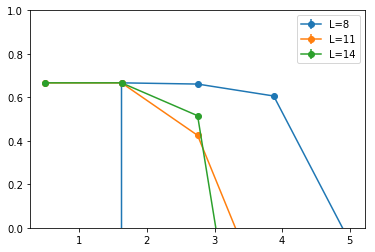

In [66]:
N_therm = int(2e4)
N_run = int(5e3)

L_range = np.linspace(8,14,3,dtype=np.int16)
T_range = np.linspace(0.5,5,10)
reps = 1
for L in L_range:
    lattice0 = np.copy(init_lattice(L))
    U_reps = np.copy(np.zeros((reps,len(T_range))))
    for rep in range(reps):
        print(L,rep)
        U = []
        for T in T_range:
            lattice,_ = np.copy(MC_simulate(lattice0,N_therm,J,1/T))
            _,properties = np.copy(MC_simulate(lattice,N_run,J,1/T))
            U.append(properties['U'])
        print(U)
        U_reps[rep][:] = U
    U_avg = np.copy(np.average(U_reps,axis=0))
    U_error = np.copy(np.std(np.asarray(U_reps),axis=0))
    plt.errorbar(T_range,U_avg,U_error,None,'o-',label='L=%s'%L,)

plt.ylim([0,1.0])
plt.legend() 
plt.show()

We can check for the values crossing visually-- it appears that this value is ~2.25. The analytical solution for the 2D Ising model is approximately ~2.27.